In [ ]:
!nvidia-smi

Mon Sep  2 14:05:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Building Mapping

In this tutorial, we are going to detect the buildings using satellite imagery. It is a binary class segmentation problem.


### Dataset
The dataset is taken from [kaggle](https://www.kaggle.com/datasets/tekbahadurkshetri/building-mapping). Feel free to test and modify the code as your requirement.

Input data are RGB satellite images. And output are binary images. Pixel value is 0 for non-buildings and pixel value is 1 for buildings.



In [ ]:
# import necessary libraries
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

from tensorflow.python.keras import Model
from tensorflow.python.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, Dropout

In [ ]:
# connect google drive
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# set the working directory
import os
os.chdir(r'/content/gdrive/MyDrive/Unet')

## Data preprocessing

In [ ]:
train_x = sorted(glob.glob('train/*_image.tif'))
train_y = sorted(glob.glob('train/*_label.tif'))
test_x = sorted(glob.glob('test/*_image.tif'))
test_y = sorted(glob.glob('test/*_label.tif'))

print(len(train_x), len(test_x))

70 30


In [ ]:
# converting training image to numpy array
train_xx = np.zeros((70, 128, 128, 3))
train_yy = np.zeros((70, 128, 128, 1))
for i, (img, mask) in enumerate(zip(train_x, train_y)):
  # if i == 1:
  #   break

  img = Image.open(img)
  np_img = np.array(img)
  train_xx[i] = np_img

  mask = Image.open(mask)
  np_mask = np.array(mask).reshape(128, 128, 1)
  train_yy[i] = np_mask

In [ ]:
# converting training image to numpy array
test_xx = np.zeros((30, 128, 128, 3))
test_yy = np.zeros((30, 128, 128, 1))
for i, (img, mask) in enumerate(zip(test_x, test_y)):

  img = Image.open(img)
  np_img = np.array(img)
  test_xx[i] = np_img

  mask = Image.open(mask)
  np_mask = np.array(mask).reshape(128, 128, 1)
  test_yy[i] = np_mask

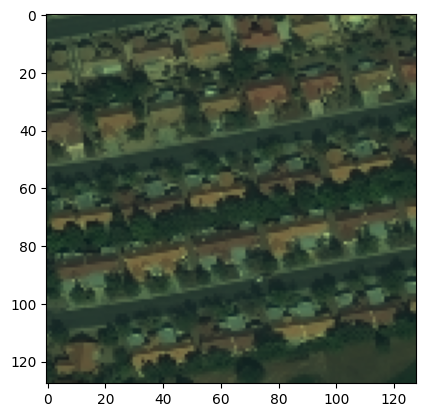

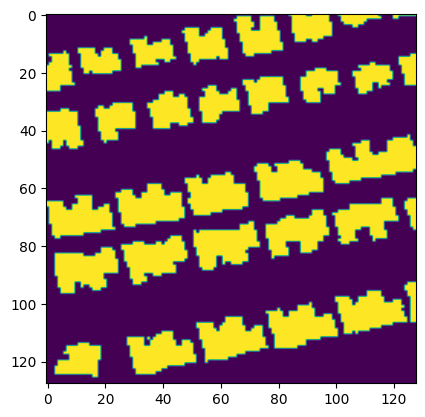

In [ ]:
# Let's plot a sample input RGB image and output image with buildings

plt.imshow(train_xx[20, :, :, :].astype('uint8'))
plt.show()
plt.imshow(train_yy[20, :, :, 0].astype('uint8'))
plt.show()

## Save to numpy format

In [ ]:
train_xx.shape

(70, 128, 128, 3)

In [ ]:
np.save('train_xx.npy', train_xx)
np.save('train_yy.npy', train_yy)
np.save("test_xx.npy", test_xx)
np.save("test_yy.npy", test_yy)

## U-Net model development
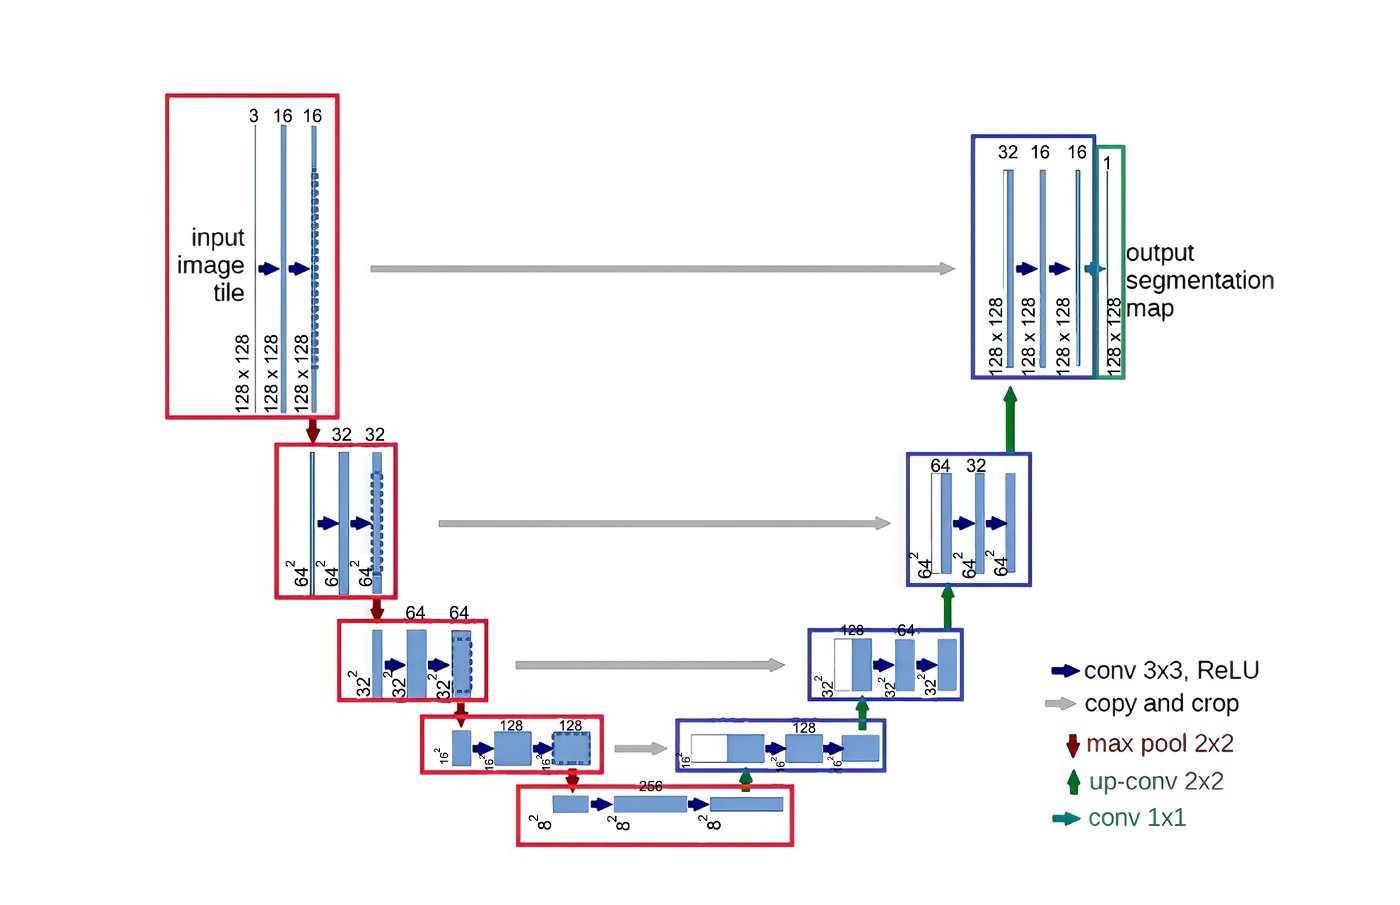


In [ ]:
x_in = Input(shape=(128, 128, 3))

'''Encoder'''
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_in)
x_temp = Dropout(0.25)(x_temp)
x_skip1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip1)
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_skip2 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip2)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_skip3 = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip3)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)

'''Decoder'''
x_temp = Conv2DTranspose(64, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip3])
x_temp = Conv2DTranspose(64, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip2])
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip1])
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)

'''Use 1 by 1 Convolution to get desired output bands'''
x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
x_out = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x_temp)
# use sigmoid activation here because output values are either 0 or 1

model = Model(inputs=x_in, outputs=x_out)

model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        dropout[0][0]                    
______________________________________________________________________________________________

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.17.0


In [ ]:
# !pip install tensorflow==2.8.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 85.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 84.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 39.5 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: goo

In [ ]:
# training model
history = model.fit(train_xx, train_yy, validation_data=(test_xx, test_yy), epochs=100, batch_size=10, verbose=1)

Epoch 1/100
7/7 [==============================] - 15s 2s/step - loss: 0.2152 - val_loss: 0.2316
Epoch 2/100
7/7 [==============================] - 15s 2s/step - loss: 0.2152 - val_loss: 0.2316
Epoch 3/100
7/7 [==============================] - 15s 2s/step - loss: 0.2152 - val_loss: 0.2316
Epoch 4/100
7/7 [==============================] - 15s 2s/step - loss: 0.2152 - val_loss: 0.2316
Epoch 5/100
7/7 [==============================] - 15s 2s/step - loss: 0.2152 - val_loss: 0.2316
Epoch 6/100
7/7 [==============================] - 16s 2s/step - loss: 0.2152 - val_loss: 0.2316
Epoch 7/100
7/7 [==============================] - 15s 2s/step - loss: 0.2152 - val_loss: 0.2316
Epoch 8/100
7/7 [==============================] - 15s 2s/step - loss: 0.2152 - val_loss: 0.2316
Epoch 9/100
7/7 [==============================] - 15s 2s/step - loss: 0.2152 - val_loss: 0.2316
Epoch 10/100
7/7 [==============================] - 15s 2s/step - loss: 0.2152 - val_loss: 0.2316
Epoch 11/100
7/7 [===========

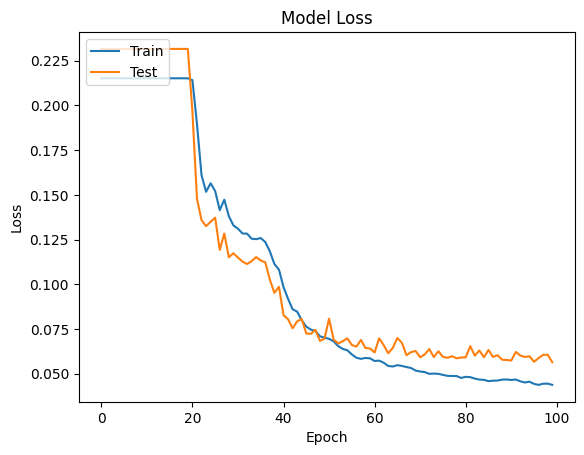

In [ ]:
# plot model loss over training and validation data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Prediction

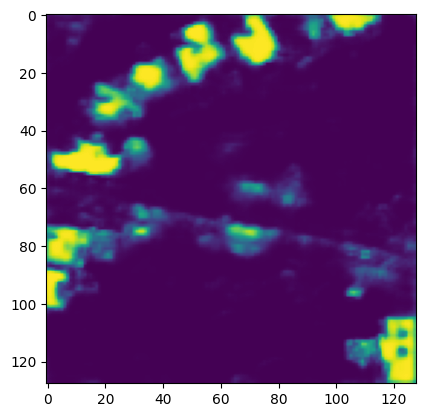

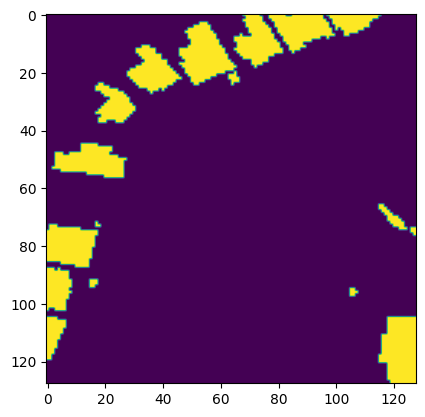

In [ ]:
# threshold = 0.4

# # prediction of the output
pred_test = model.predict(test_xx)
# pred_test = (pred_test > threshold).astype(np.uint8)
# print(pred_test.shape)

#let's comare random predicted and actial y values
plt.imshow(pred_test[20, :, :, 0])
plt.show()
plt.imshow(test_yy[20,:,:,0])
plt.show()

This is not an operational model with high accuracy. But with more layers and with more data, we can develop this architecture in to an operational model with high accuracy.

## Convert numpy array to image

In [ ]:
from PIL import Image
import os
def convert_numpy_array_to_img(in_npy, out_folder, channel=3):
    n = in_npy.shape[0]
    for i in range(n):
        if channel==3:
            image = Image.fromarray(in_npy[i].astype('uint8'))
            image.save(os.path.join(out_folder, f"{i}_image.tif"))

        else:
            image = Image.fromarray(in_npy[i, :, :, 0])
            image.save(os.path.join(out_folder, f"{i}_label.tif"))

In [ ]:
# data is already randomized and split in to training / test sets. So we can go ahead and use them as it is.
x_train = np.load('train_xx.npy').astype('float32')
y_train= np.load('train_yy.npy').astype('float32')
x_test = np.load('test_xx.npy').astype('float32')
y_test = np.load('test_yy.npy').astype('float32')

print("x_train shape", x_train.shape)
print("y_train shape", y_train.shape)
print("y_test shape", x_test.shape)
print("y_test shape", y_test.shape)

x_train shape (70, 128, 128, 3)
y_train shape (70, 128, 128, 1)
y_test shape (30, 128, 128, 3)
y_test shape (30, 128, 128, 1)


In [ ]:
convert_numpy_array_to_img(x_train, 'train')
convert_numpy_array_to_img(y_train, 'train', channel=1)

convert_numpy_array_to_img(x_test, 'test')
convert_numpy_array_to_img(y_test, 'test', channel=1)